## Demo code for kernel density estimation

This notebook illustrates kernel density estimation, which is basically the same as kernel smoothing 
for regression. The estimator is given by 
$$ {\hat f}(x) = \frac{1}{nh^p} \sum_{i=1}^n K\left( \frac{X_i - x}{h}\right)$$
where $K(u)$ is a smoothing kernel that integrates to one. 
As in our previous notebook, we show the use of [different kernels](https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use), illustrating that it's the bandwidth that matters most, not the shape of the kernel.



In [30]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline


In [147]:
def gaussian_kernel(u, h):
    return (1./np.sqrt(2*np.pi*h**2)) * np.exp(-(u)**2/(2*h**2))

def kde_with_kernel(kernel, X, x, h):
    K = np.zeros(len(x)*len(X)).reshape(len(x), len(X))
    for j in np.arange(K.shape[1]):
        K[:,j] = kernel(x-X[j], h)
    fhat = np.mean(K, axis=1)
    return fhat


We read in the [Fiji earthquake data](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/quakes.html).

In [148]:
quakes = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/smoothing/fijiquakes.dat', sep='\s+')
quakes

,Obs.,lat,long,depth,mag,stations
0,1,-20.42,181.62,562,4.8,41
1,2,-20.62,181.03,650,4.2,15
2,3,-26.00,184.10,42,5.4,43
3,4,-17.97,181.66,626,4.1,19
4,5,-20.42,181.96,649,4.0,11
...,...,...,...,...,...,...
995,996,-25.93,179.54,470,4.4,22
996,997,-12.28,167.06,248,4.7,35
997,998,-20.13,184.20,244,4.5,34
998,999,-17.40,187.80,40,4.5,14


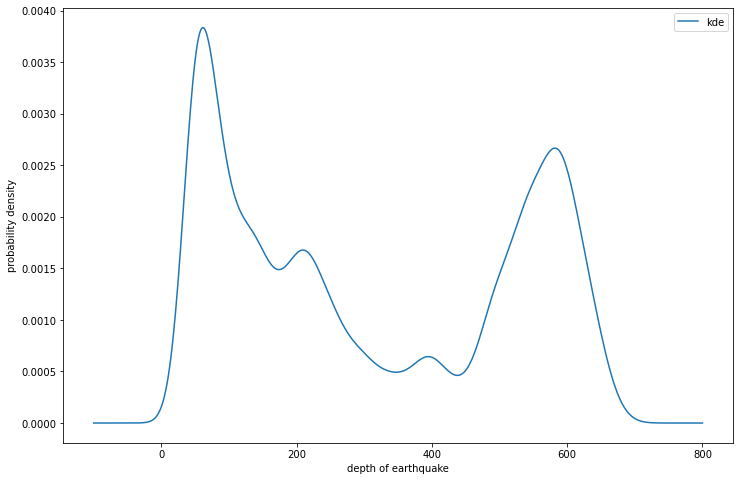

In [154]:
X = quakes['depth']
x = np.linspace(-100, 800, 500)

fhat = kde_with_kernel(gaussian_kernel, X, x, 20)
plt.figure(figsize=(12, 8))
plt.plot(x, fhat, label='kde')
plt.xlabel('depth of earthquake')
plt.ylabel('probability density')
_ = plt.legend()


In [37]:
def first_available_natural(c):
    for i in np.arange(len(c)):
        if not(i in c):
            return i
    return i+1

def gaussian_posterior_mean(xk, mu0, tau0, sigma):
    n = len(xk)
    se2 = sigma**2/n
    wn = 1 / (1 + se2/tau0**2)
    mu = wn * np.mean(xk) + (1-wn) * mu0
    tau = np.sqrt(se2 * wn)
    return mu, tau

def plot_density(x, c, mu0, tau0, sigma, step):
    from collections import Counter
    tables = Counter(c.data)
    xs = np.linspace(-100, 800, 500)
    clear_output(wait=True)
    plt.figure(figsize=(12,7))
    f = np.zeros(len(xs))
    for t in tables:
        xt = x[c==t]
        nt = len(xt)
        mut, taut = gaussian_posterior_mean(xt, sigma, mu0, tau0)
        ft =  (nt/(n + alpha)) * norm.pdf(xs, loc=mut, scale=np.sqrt(taut**2 + sigma**2))
        f = f + ft
        plt.plot(xs, ft, alpha=.2)
    f0 = (alpha/(n + alpha)) * norm.pdf(xs, loc=mu0, scale=sigma)
    plt.plot(xs, f, linewidth=2, color='gray')
    plt.scatter(x, np.zeros(len(x)), marker='|', linewidth=.5)
    plt.xlabel('earthquake depth (km)')
    plt.ylabel('probability density')
    plt.title('Gibbs step: %d' % step)
    plt.show()
    sleep(.1)

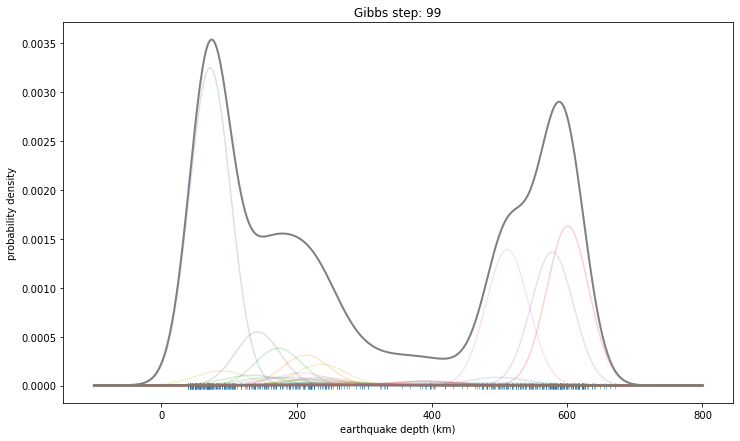

In [156]:
sample_size = 500
sample = np.random.choice(np.arange(len(X)), size=sample_size)
x = np.array(X[sample])
c = np.random.choice(np.arange(10), size=len(x))
x = np.ma.array(x, mask=False)
c = np.ma.array(c, mask=False)

mu0 = np.mean(x)
sigma = 30
tau0 = 70
alpha = 50
n = len(x)
gibbs_steps = 100
num_clusters = []
for step in np.arange(gibbs_steps):
    clusters = np.unique(c.data)
    num_clusters.append(len(clusters))

    for i in np.arange(len(x)):
        xi = x[i]
        x.mask[i] = True
        c.mask[i] = True
        clusters = np.unique(c.data)
        clusters = np.append(clusters, first_available_natural(clusters))
        z = np.zeros(len(clusters))
        for k in np.arange(len(clusters)):
            xk = np.array(x[c==clusters[k]])
            nk = len(xk)
            if nk > 0:
                mu, tau = gaussian_posterior_mean(xk, sigma, mu0, tau0)
                z[k] = (nk / (n-1+alpha)) * norm.pdf(xi, loc=np.mean(xk), scale=30)
        z[-1] = (alpha / (n-1+alpha)) * norm.pdf(xi, loc=mu0, scale=tau0)
        weights = z/np.sum(z)
        k = np.random.choice(np.arange(len(weights)), size=1, p=weights)
        c[i] = clusters[k]
        x.mask[i] = False
        c.mask[i] = False
        
    if step > 0:
        plot_density(x, c, mu0, tau0, sigma, step)




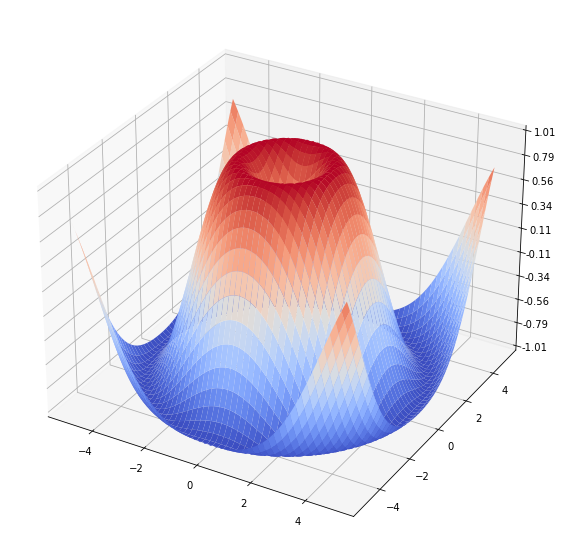

In [54]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))

# Make data.
X = np.arange(-5, 5, 0.01)
X = np.linspace(-5, 5, 500)
Y = np.linspace(-5, 5, 500)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=1)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

plt.show()

In [59]:
X = quakes['mag']
np.max(X)

6.4

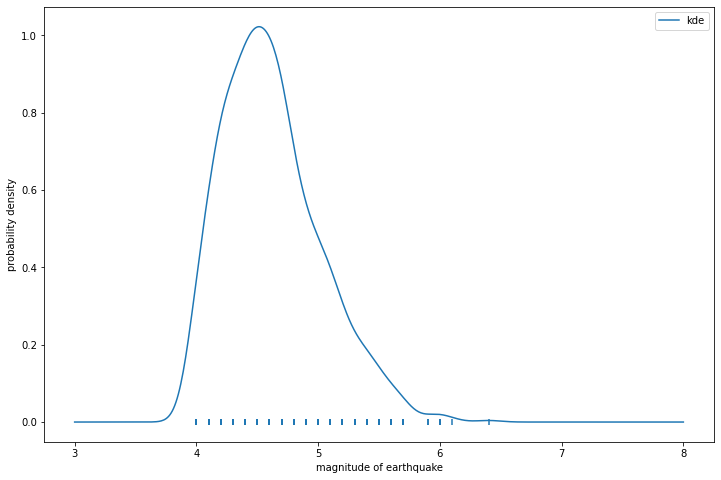

In [157]:
X = quakes['mag']
x = np.linspace(3, 8, 500)

fhat = kde_with_kernel(gaussian_kernel, X, x, .1)
plt.figure(figsize=(12, 8))
plt.plot(x, fhat, label='kde')
plt.scatter(X, np.zeros(len(X)), marker='|')
plt.xlabel('magnitude of earthquake')
plt.ylabel('probability density')
_ = plt.legend()


In [158]:
X = quakes['lat', 'long']
#x = np.linspace(3, 8, 500)

#fhat_gaussian = kde_with_kernel(gaussian_kernel, X, x, .1)
plt.figure(figsize=(12, 8))
#plt.plot(x, fhat_gaussian, label='kde')
plt.scatter(X, np.zeros(len(X)), marker='|')
plt.xlabel('magnitude of earthquake')
plt.ylabel('probability density')
_ = plt.legend()


KeyError: ('lat', 'long')

In [161]:
from scipy.stats import norm

def gaussian_kernel2(u, h):
    return gaussian_kernel(u[:,0], h) * gaussian_kernel(u[:,1],h)
    #return norm.pdf(u[0], scale=h) * norm.pdf(u[1], scale=h)

def kde2_with_kernel(kernel, X, x, h):
    K = np.zeros(len(x)*len(X)).reshape(len(x), len(X))
    for j in np.arange(K.shape[1]):
        K[:,j] = kernel(x-X[j], h)
    fhat = np.mean(K, axis=1)
    return fhat


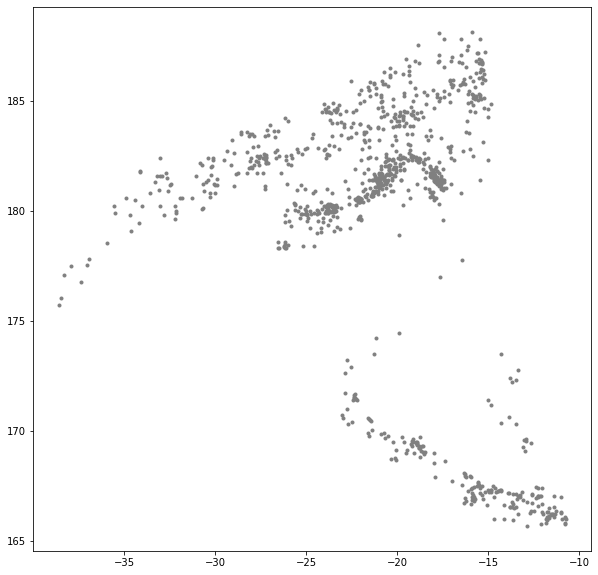

In [160]:
Q = quakes[['lat', 'long']]
X = np.array([Q['lat'],Q['long']]).T
plt.figure(figsize=(10,10))
plt.scatter(x=X[:,0], y=X[:,1], marker='.', color='gray')

In [162]:
x1 = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 300)
x2 = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 300)
x = np.array([x1,x2]).T
x.shape

(300, 2)

In [180]:

np.min(x1), np.max(x1)

(-38.59, -10.72)

In [173]:
xx.shape
yy.shape
z = np.array(fhat).reshape(len(fhat), 1)
Z = z @ z.T
Z.shape

(300, 300)

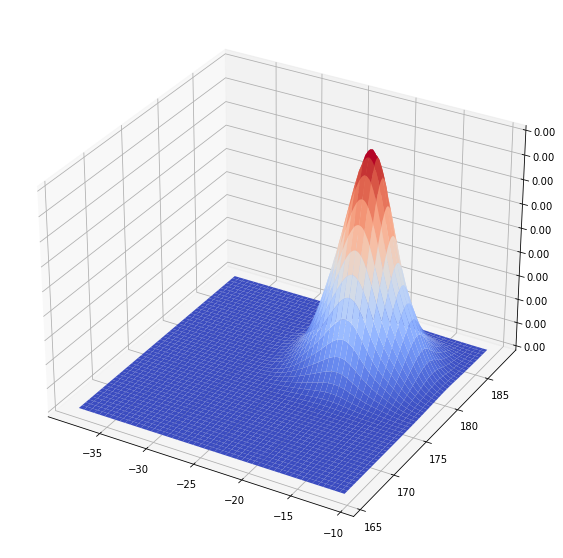

0.5108438529121202

In [182]:
fhat = kde2_with_kernel(gaussian_kernel2, X, x, h=2)
xx, yy = np.meshgrid(x1, x2)
z = np.array(fhat).reshape(len(fhat), 1)
Z = z @ z.T


# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm,linewidth=1)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

plt.show()
np.sum(Z)

In [202]:
x

array([[-38.59      , 165.67      ],
       [-38.4967893 , 165.74511706],
       [-38.4035786 , 165.82023411],
       [-38.31036789, 165.89535117],
       [-38.21715719, 165.97046823],
       [-38.12394649, 166.04558528],
       [-38.03073579, 166.12070234],
       [-37.93752508, 166.1958194 ],
       [-37.84431438, 166.27093645],
       [-37.75110368, 166.34605351],
       [-37.65789298, 166.42117057],
       [-37.56468227, 166.49628763],
       [-37.47147157, 166.57140468],
       [-37.37826087, 166.64652174],
       [-37.28505017, 166.7216388 ],
       [-37.19183946, 166.79675585],
       [-37.09862876, 166.87187291],
       [-37.00541806, 166.94698997],
       [-36.91220736, 167.02210702],
       [-36.81899666, 167.09722408],
       [-36.72578595, 167.17234114],
       [-36.63257525, 167.24745819],
       [-36.53936455, 167.32257525],
       [-36.44615385, 167.39769231],
       [-36.35294314, 167.47280936],
       [-36.25973244, 167.54792642],
       [-36.16652174, 167.62304348],
 

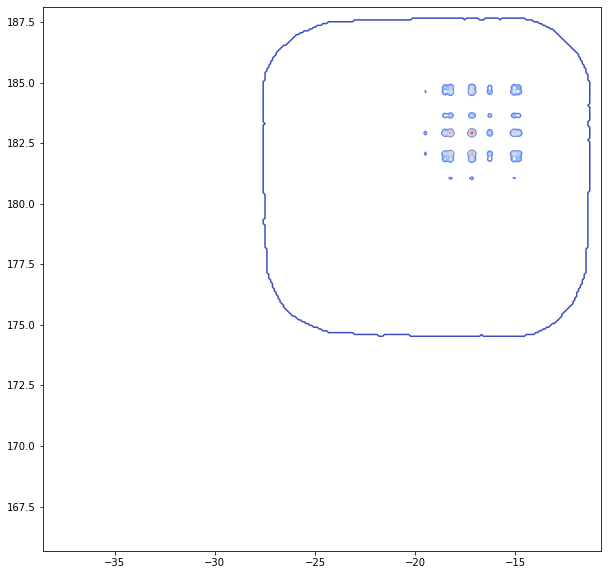

In [198]:
fhat = kde2_with_kernel(gaussian_kernel2, X, x, h=.1)
xx, yy = np.meshgrid(x1, x2)
z = np.array(fhat).reshape(len(fhat), 1)
Z = z @ z.T


# Plot the surface.
fig, ax = plt.subplots(figsize=(10,10))
surf = ax.contour(xx, yy, Z, cmap=cm.coolwarm)
plt.show()


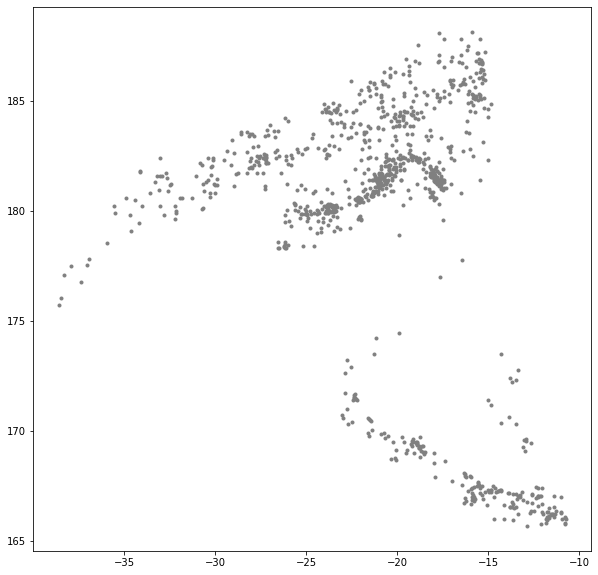

In [203]:
plt.figure(figsize=(10,10))
plt.scatter(x=X[:,0], y=X[:,1], marker='.', color='gray')